In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import pytesseract
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Flatten, Dense, Reshape, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from torch.optim import AdamW

from transformers import (
    BertTokenizerFast, 
    BertConfig, 
    BertForMaskedLM, 
    AdamW, 
    Trainer, 
    TrainingArguments, 
    DataCollatorForSeq2Seq
)
import torch
from torch.utils.data import Dataset

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

/Users/aleksandrekhundzakishvili/Desktop/HandwrittenDigits/CNN/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Start

In [3]:
df=pd.read_csv('dataset/Training/training_labels.csv')

df.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


In [4]:
img=cv2.imread('dataset/Training/training_words/0.png',cv2.IMREAD_GRAYSCALE)

img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

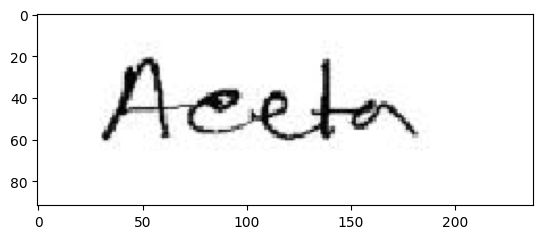

In [5]:
plt.imshow(img,cmap='gray')

# Data Collection

In [6]:
def one_hot_encoded_Y(df):
    return pd.get_dummies(df['MEDICINE_NAME'],dtype=int)

In [7]:
def load_images(image_paths,target_size=(128,32)): # width,height

    imagess=[]

    for path in image_paths:

        img=cv2.imread(path)

        img=cv2.resize(img,target_size)

        img=img.astype('float32')/255.0

        imagess.append(img)

    imagess=np.array(imagess)
    
    imagess=imagess.reshape(imagess.shape[0],32,128,3)

    return imagess

In [11]:
def XY(folder):
    lower=folder.lower()
    
    df=pd.read_csv(f"dataset/{folder}/{lower}_labels.csv")
    
    Y=one_hot_encoded_Y(df)
    
    image_folder=f"dataset/{folder}/{lower}_words/"
    image_paths=[os.path.join(image_folder,filename) for filename in df['IMAGE']]

    X=load_images(image_paths)

    return X,Y

# OCR Model with charachter level BERT 

In [22]:
def preprocess_image(image_path):
    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    img = cv2.resize(img, (128, 32))  

    _, img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return img

In [20]:
def extract_text_with_ocr(image_path):
    preprocessed_image = preprocess_image(image_path)
    
    img = Image.fromarray(preprocessed_image)
    
    extracted_text = pytesseract.image_to_string(img)
    
    return extracted_text

In [25]:
def XYocr(folder):
    lower=folder.lower()
    df=pd.read_csv(f"dataset/{folder}/{lower}_labels.csv")
    Y=df['MEDICINE_NAME']

    image_folder=f"dataset/{folder}/{lower}_words/"
    image_paths=[os.path.join(image_folder,filename) for filename in df['IMAGE']]
    X = [extract_text_with_ocr(image_path) for image_path in image_paths]

    return X,Y

In [26]:
xTest,yTest=XYocr("Testing")

In [27]:
count_non_form_feed = sum(1 for value in xTest if value != '\x0c')
count_non_form_feed

780

In [28]:
len(xTest)

780

In [29]:
print(xTest[124])
print(yTest[124])

foeehan

Baclon


In [30]:
xTrain,yTrain=XYocr("Training")
xVal,yVal=XYocr("Validation")

In [36]:
# Define your custom vocabulary (character-level)
vocab_list = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,!?")  
vocab = {char: i for i, char in enumerate(vocab_list, start=1)} 
vocab["[PAD]"] = 0  # Add padding token
vocab["[MASK]"] = len(vocab) + 1  # Mask token
vocab["[CLS]"] = len(vocab) + 2  # CLS token
vocab["[SEP]"] = len(vocab) + 3  # SEP token
vocab["[UNK]"] = len(vocab) + 4  # Unknown token

# Save the vocab to a file
vocab_file = "vocab.txt"
with open(vocab_file, 'w') as f:
    for token in vocab:
        f.write(token + "\n")

# Initialize the tokenizer with the custom vocabulary
tokenizer = BertTokenizerFast(vocab_file=vocab_file)
tokenizer.pad_token = "[PAD]"
tokenizer.mask_token = "[MASK]"
tokenizer.cls_token = "[CLS]"
tokenizer.sep_token = "[SEP]"
tokenizer.unk_token = "[UNK]"

# Save tokenizer to output directory
tokenizer_output_dir = "output_tokenizer"
os.makedirs(tokenizer_output_dir, exist_ok=True)
tokenizer.save_pretrained(tokenizer_output_dir)

# Create a custom Dataset class for loading the data
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data, tokenizer, max_length=128):
        self.x_data = x_data
        self.y_data = y_data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        
        inputs = self.tokenizer(x, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        labels = self.tokenizer(y, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': labels['input_ids'].squeeze()
        }

# Prepare datasets
train_dataset = CustomDataset(xTrain, yTrain, tokenizer)
val_dataset = CustomDataset(xVal, yVal, tokenizer)
test_dataset = CustomDataset(xTest, yTest, tokenizer)

# Set up BERT model configuration
config = BertConfig(
    vocab_size=len(vocab), 
    hidden_size=256,
    num_hidden_layers=6,
    num_attention_heads=8,
    intermediate_size=512,
    max_position_embeddings=512
)

# Initialize the BERT model for masked language modeling
model = BertForMaskedLM(config)

# Use PyTorch-native AdamW optimizer (instead of deprecated transformers.AdamW)
from torch.optim import AdamW  

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)  # Updated

# Updated TrainingArguments with necessary logging and reporting fixes
training_args = TrainingArguments(
    output_dir="output_model",  # Save model outputs here
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save model at the end of each epoch
    logging_dir=None,  # No need to log
    logging_steps=1,  # Reduced logging
    logging_first_step=False,  # Do not log first step
    report_to="none",  # Disable WANDB and other reporting
    save_steps=10,
    save_total_limit=1,  # Keep only the most recent model
    load_best_model_at_end=True,  # Load the best model at the end
    disable_tqdm=False,  # Keep tqdm progress bar
    fp16=False  # Disable automatic mixed precision
)

# Suppress FutureWarnings (Optional)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Custom function to compute accuracy
def compute_accuracy(p):
    preds, labels = p
    preds = torch.tensor(preds)  # Convert to tensor
    preds = torch.argmax(preds, dim=-1)
    return {"accuracy": accuracy_score(labels.flatten(), preds.flatten())}

# Set up Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Training dataset
    eval_dataset=val_dataset,  # Validation dataset
    optimizers=(optimizer, None),
    compute_metrics=compute_accuracy
)

# Train the model with epoch-wise output
trainer.train()

# Evaluate the model after training on the validation set
final_metrics = trainer.evaluate(val_dataset)
final_accuracy = final_metrics["eval_accuracy"]
final_loss = final_metrics["eval_loss"]

# Evaluate the model on the test set
test_metrics = trainer.evaluate(test_dataset)
test_accuracy = test_metrics["eval_accuracy"]
test_loss = test_metrics["eval_loss"]

# Display epoch-wise output and final test results
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>={ACCELERATE_MIN_VERSION}'`